### Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

# **Project Title:** Exploring Toronto Neighborhoods and Identifying Suitable Location for Opening Chinese Restaurant

## Table of contents
* [Introduction and Background](#1)
* [Data Acquisition and Pre-processing](#2)
* [Methodology](#3)
* [Predictive Analysis](#4) 
* [Results and Discussion](#5)
* [Conclusion](#6)

## 1. Introduction and Background <a id='1'></a>

This coursera IBM capstone project aims at exploring a business problem, business understanding and providing scientific solution by adopting the data science methodologies on real dataset.
 In this project, we follow the data science methodologies such as **problem understanding**, **data preparation**, **data modelling** and **evaluation**.


### 1.1 Problem Statement
### *“Exploring Toronto Neighborhoods and Identifying Suitable Location for Opening Chinese Restaurant”*

### 1.2 Problem Description
Toronto is the capital city of the Canadian province of Ontario. With a recorded population of 2,731,571 in 2016. The demographics of Toronto, Ontario, Canada make Toronto one of the most multicultural and multiracial cities in the world. In 2016, 51.5% of the residents of the city proper belonged to a visible minority group. Toronto also has established ethnic neighbourhoods such as the multiple *Chinatowns, Corso Italia, Little Italy, Little India, Greektown, Koreatown, Little Jamaica, Little Portugal and Roncesvalles*, which celebrate the city's multiculturalism. According to the ethnic breakdown of 2016 census Chinese ethnic group is on top (12.5% of total population) among the most prevalent ethnic origins in the City of Toronto.

Keep in mind the population of *Chinese ethnic group*, we aim at identifying suitable location for *opening a new Chinese restaurant*. For this purpose, we use the spatial and non-spatial data of Toronto neighborhoods and analyse the dataset. The data analysis includes *exploring the population distributions in top visible minority groups in neighborhoods, exploring relationship between venues in the neighborhoods, identifying the relationship between neighborhoods and existing Chinese restaurants, identifying relationship between Chinese population and Chinese restaurants, and clustering analysis* for identifying suitable location for opening new Chinese restaurant.

<div style= "text-align:center">
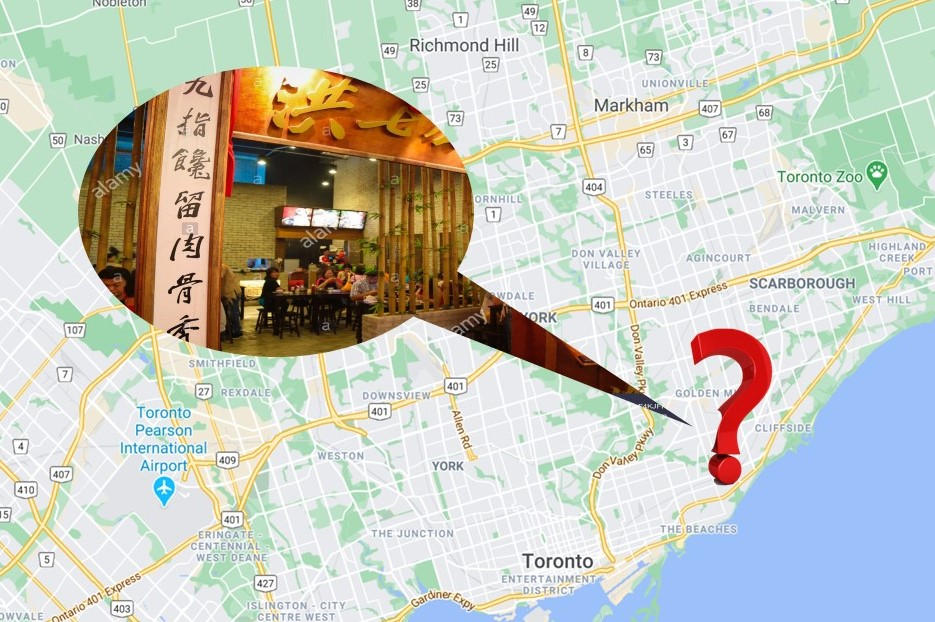
</div>


The findings give an overview for investors interesting in opening new Chinese restaurant by taking into account Chinese population and number of existing restaurants in the vicinity. The analysis also provides information to customers about neighborhoods with lots of option for Chinese restaurants.

## 2. Data Acquisition and Pre-processing <a id="2"></a>

### 2.1 Data Sources, Pre-processing and Data Cleaning
- we used Wikipedia data “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to get all the information about the neighborhoods including their postal code, borough & the name of all the neighborhoods present in Toronto.

- The population information is extracted from Wikipedia page https://en.wikipedia.org/wiki/Demographics_of_Toronto. We used demographic data to get population information about Chinese ethnic group in Toronto neighborhoods. The population information together with number of existing restaurants allow us to explore the relationship between population and existing restaurants.

- Spatial information such as latitude and longitude of Toronto neighborhoods is extracted from “https://cocl.us/Geospatial_data”

- Information about various venues in Toronto and their spatial information are extracted using Foursquare’s API. Detail on API can be found on https://developer.foursquare.com/docs. We are interested in existing Chinese restaurants. Therefore, we extract the number of existing restaurants in each neighborhoods. This allows us to explore the relationship between neighborhoods and Chinese Restaurant.


The pre-processing and data cleaning involve scraping Toronto neighborhood data, extracting latitude and longitude of neighborhoods, scraping venue items, extracting Chinese population in neighborhoods and number of existing Chinese restaurants. All the extracted data will be convert in to data frames for further analysis. Each pre-processing and data cleaning steps are discussed, and documented as markdowns together with code in the jupyter notebook.

In [ ]:
!pip install beautifulsoup4
!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
!conda install -c conda-forge wikipedia --yes 
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

### 2.2 Extract Toronto Neighborhood Data
- Request the wikipedia page to scrape List_of_postal_codes
- Extract table and convert in to data frame
- Rename Postal code and neighborhood columns labels



In [2]:
from IPython.display import display_html
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'html')
table = str(soup.table)
#display_html(table, raw = True)
dataframe = pd.read_html(table)
df = dataframe[0]
df.rename(columns= {'Postal Code': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace = True)
df.shape

(180, 3)

### 2.3 Cleaning data in the Dataframe
- Drop rows that have Borough = **Nont assigned**
- Combine the neighbourhood with same postalcode
- Add borough value to the neighborhood where the value = **Not assigned** 

In [3]:
filter_df = df[df['Borough'] != "Not assigned"]
# Combining the neighbourhoods with same Postalcode
df2 = filter_df.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# add the not assigned neighbour from Borough
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned', df2['Borough'], df2['Neighborhood'])
df2.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
# show the dataframe shape (no of rows and columns)
df2.shape

(103, 3)

In [5]:
# group by based on  Borough and postalCode
df3 = df2.groupby(['Borough', 'PostalCode'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df3.head()

,Borough,PostalCode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [6]:
df3.shape

(103, 3)

### 2.4 Import Geospatial Information (Latitude and Longitude) of neighborhoods 
- Change the postal code column name
- Merge lat and long of the locations 

In [7]:
lat_log_df = pd.read_csv('https://cocl.us/Geospatial_data')
lat_log_df.rename(columns= {'Postal Code': 'PostalCode'}, inplace = True )
lat_log_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# merge df to integrate lat and long in new dataframe
toronto_df = pd.merge (df3, lat_log_df, on = "PostalCode")
toronto_df.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [10]:
# print the total number of boroughs and neighborhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


### 2.5 Visualization of Toronto Neighborhoods 
- Install geopy libraray to extract lat and long from the given address of the location
- Nominatim converts the given address into lat and long values

In [11]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [12]:
#Use geopy library to get the latitude and longitude values of Toronto city.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:
# visualize Toronto map with neighorhoods
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

 
<div style= "text-align:center">
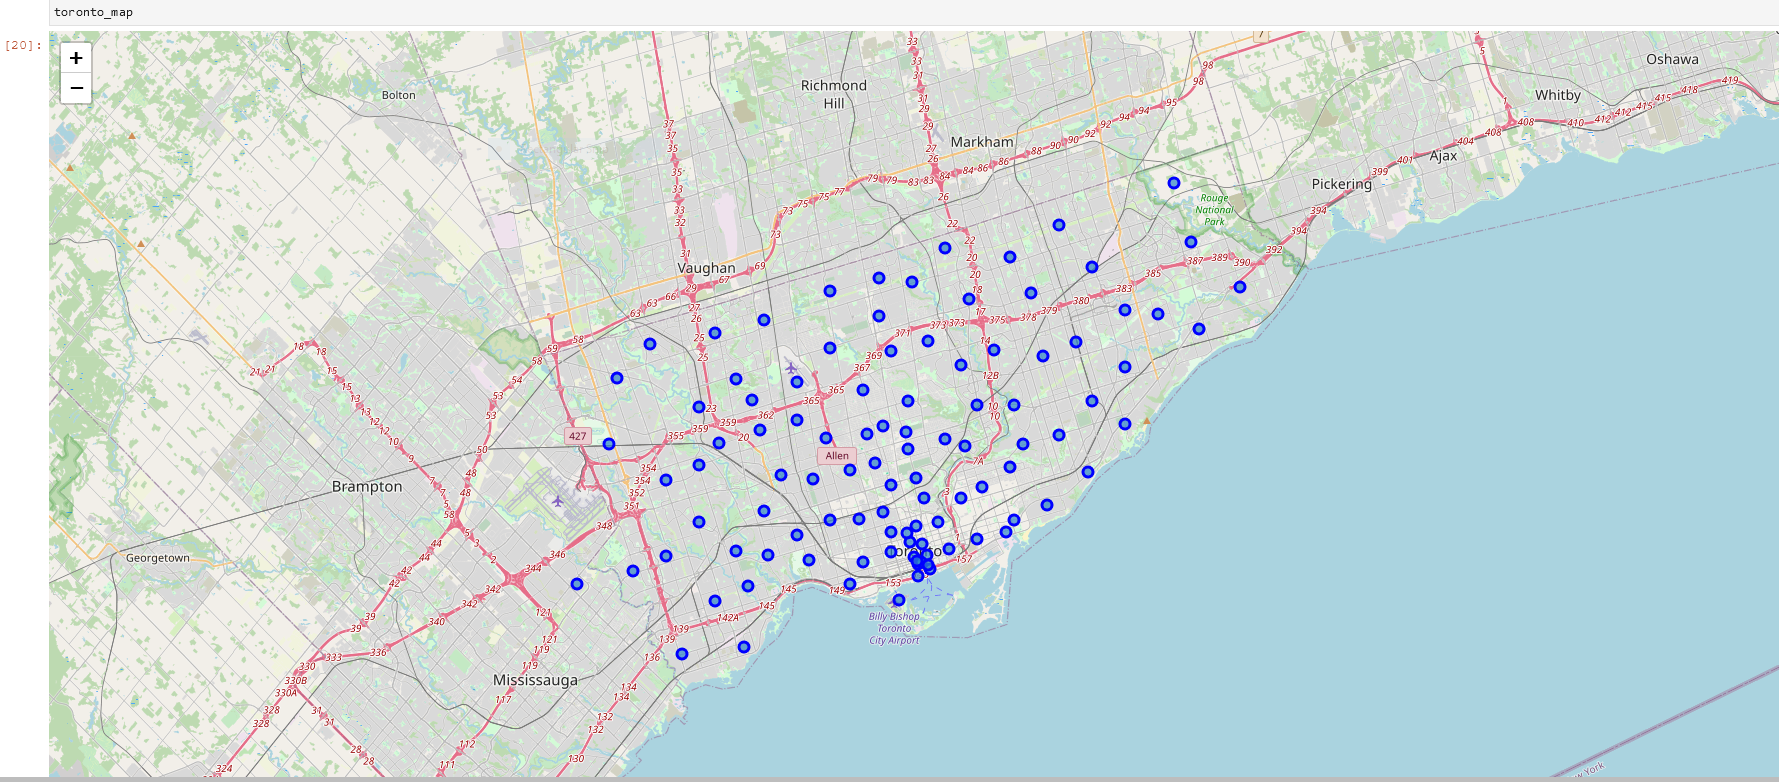
<div>
     <a>Visualization of neighborhoods in Toronto using Folium Map Python library
    </a>
    </div>
</div>

In [15]:
import wikipedia as wp

## 3. Methodology <a id="3"></a>

In this project, our methodolgy consist of multiple components including: 
- Extracting Demographics data about the Toronto & the Neighborhoods from Wikipedia
- Extracting Location Data and Venues using Foursquare API in Toronto Nnighborhoods
- Exploring the Relationship between Neighborhoods and Chinese Restaurant
- Extracting Population of Chinese Ethnic Group in Neighborhoods
- Identifying Relationship between Chinese Population and Chinese Restaurants

### 3.1 Extracting Demographics data about the Toronto & the Neighborhoods from Wikipedia
- Extract Demographics data of Toronto & the Neighborhoods in it.
- The top visible-minority groups per Community Council (2016 Census) [34] are as follows:
    - Toronto & East York (847,045): White: 65.3%, Chinese: 8.9%, South Asian: 6.7%, Black: 5.6%
    - North York (638,100): White: 47.4%, Chinese: 14.0%, South Asian: 8.5%, Filipino: 8.0%, West Asian: 5.3%, Black: 5.2%
    - Scarborough (623,135): White: 26.5%, South Asian: 25.4%, Chinese: 19.0%, Black: 10.8%, Filipino: 8.4%
    - Etobicoke York (583,395): White: 48.9%, Black: 15.7%, South Asian: 11.9%, Latin American: 5.6%


In [16]:
#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [17]:
# TORONTO & EAST YORK population distribution by ethnicity 
toronto_eastyork_population_df = pd.read_html(html, header = 0)[12]
toronto_eastyork_population_df = toronto_eastyork_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
toronto_eastyork_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN


In [18]:
# NORTH YORK population distribution by ethnicity 
northyork_population_df = pd.read_html(html, header = 0)[13]
northyork_population_df = northyork_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
northyork_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# SCARBOROUGH population distribution by ethnicity 
Scarborough_population_df = pd.read_html(html, header = 0)[14]
Scarborough_population_df = Scarborough_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scarborough_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN


In [20]:
#ETOBICOKE & YORK population distribution by ethnicity 
etobicoke_york_population_df = pd.read_html(html, header = 0)[15]
etobicoke_york_population_df = etobicoke_york_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
etobicoke_york_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Extracting Location Data and Venues using Foursquare API in Toronto Nnighborhoods
- Foursquare API is usedto retrieve informtion about the places present in the neighborhoods of Toronto. The API requires credentials such as client_id, client_secret, version and limit.
- We are intrested in 100 popular spots for each neighborhood within a radius of 1km.

In [21]:
import json
from pandas.io.json import json_normalize

In [22]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: WZD5NZVIFHGTRTY2ERSVJMSYISTZBM2LX1OLE2SIWZ33UQF2
CLIENT_SECRET:ZCZEWBBX0QNITTEWH43TRCF5WJQC5M2D3RUJW04KJVEIDP0S


In [23]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

In [24]:
# extract category tye and filter
def extract_categories(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
# flatten JSON response and fiter venues 
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues.head()


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Nathan Phillips Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",43.652270,-79.383516
2,Indigo,"[{'id': '4bf58dd8d48988d114951735', 'name': 'B...",43.653515,-79.380696
3,CF Toronto Eaton Centre,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",43.654447,-79.380952
4,Chatime 日出茶太,"[{'id': '52e81612bcbc57f1066b7a0c', 'name': 'B...",43.655542,-79.384684


In [26]:
# filter the categories
nearby_venues['venue.categories'] = nearby_venues.apply(extract_categories, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,CF Toronto Eaton Centre,Shopping Mall,43.654447,-79.380952
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


### Explore nearby Venues around Toronto Neighborhoods
- Extract 100 Venues in the radius of 500 metres 

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


In [29]:
# group by the Venues based on neighborhood 
toronto_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,9,9,9,9,9,9


In [30]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories.


In [31]:
# check venues categories and no of avaliable venues
print (toronto_venues['Venue Category'].value_counts())


Coffee Shop          192
Café                  93
Restaurant            67
Park                  52
Pizza Place           50
                    ... 
Opera House            1
Auto Workshop          1
Social Club            1
Beach                  1
College Cafeteria      1
Name: Venue Category, Length: 277, dtype: int64


- We have 274 unique categories. Out of 274 venues, we are intrested in ***Chinese Restaurants***
- We did hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighborhoods.

In [32]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### 3.3 Exploring the Relationship between Neighborhoods and Chinese Restaurants
 - Extract Chinese Restaurant column from grouped df 
 - Merge the extracted ***toronto_grouped*** to actual ***toronto_df*** dataframe


In [33]:
# merge dataframe
toronto_chinese_rest = toronto_grouped[['Neighborhood', 'Chinese Restaurant']]
toronto_chinese_rest.head()

,Neighborhood,Chinese Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619
3,Bayview Village,0.250000
4,"Bedford Park, Lawrence Manor East",0.000000


In [34]:
toronto_chinese_merged_df = pd.merge(toronto_df, toronto_chinese_rest, on='Neighborhood')
toronto_chinese_merged_df.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Chinese Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.055556
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.000000
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000


### Visualization of Neighborhoods with Chinese Restaurants

In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

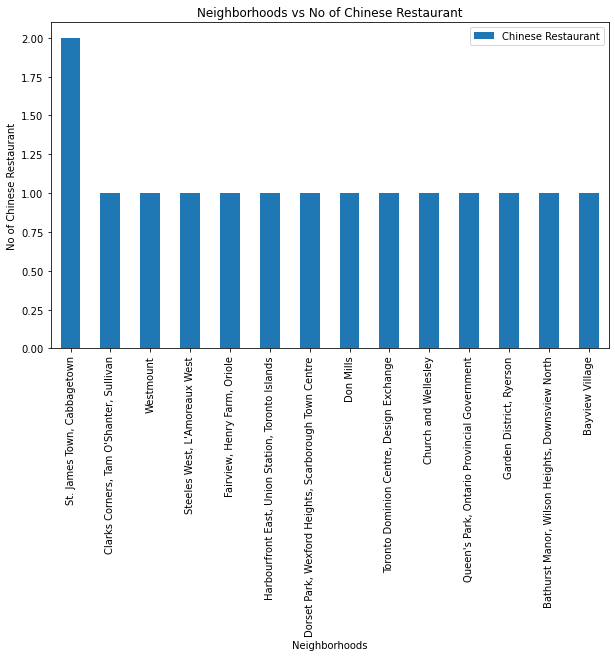

In [82]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Chinese Restaurant'].sum())
graph = graph.sort_values(by ='Chinese Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Chinese Restaurant")
plt.title("Neighborhoods vs No of Chinese Restaurant")
plt.show()

### 3.3 Extracting Population of Chinese Ethnic Group in Neighborhoods   
- we are intrested in population of Chinese ethinic group in each Riding
- we have calculated Percentage 	Population  in each Riding


In [83]:
#Merge all the population table with the ethnic percentage by neighborhood
etob_toro = etobicoke_york_population_df.append(toronto_eastyork_population_df,sort=True).reset_index()
etob_toro.drop('index',axis=1,inplace=True)

north_scarb = northyork_population_df.append(Scarborough_population_df,sort=True).reset_index()
north_scarb.drop('index',axis=1,inplace=True)

pop_ethnic_df = north_scarb.append(etob_toro,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)


pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- extract neighboors with highest Chinese population given in the above merged df

In [84]:
#extract chinese population in percentage  from all ethinic columns 
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Chinese')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'Chinese')]
pop_chinese_df = pd.DataFrame(temp).reset_index()
pop_chinese_df.drop('index',axis=1,inplace=True)

pop_chinese_df.head()



,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN,NaN,NaN
4,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#retaining only Chinese ethnic percentage & the neighborhood name 
columns_list = pop_chinese_df.columns.to_list()
pop_chinese_df_percentage = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_chinese_df.shape[0]):
    for j in columns_list:
        #print(j)
        if pop_chinese_df.at[i, j] == 'Chinese':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_chinese_df_percentage = pop_chinese_df_percentage.append({'Riding':pop_chinese_df.at[i, 'Riding'], 'Population':pop_chinese_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_chinese_df.at[i, j], 'Percentage': pop_chinese_df.at[i, percent_col]},ignore_index=True)

pop_chinese_df_percentage.head()

,Ethnicity,Percentage,Population,Riding
0,Chinese,25.9,117405.0,Willowdale
1,Chinese,32.4,109060.0,Don Valley North
2,Chinese,11.2,101790.0,Don Valley West
3,Chinese,8.9,93170.0,Don Valley East
4,Chinese,10.7,110450.0,Scarborough Centre


In [86]:
#chines population in each Riding
pop_chinese_df_percentage['Chinese Population'] = (pop_chinese_df_percentage['Percentage'] * pop_chinese_df_percentage['Population'])/100
pop_chinese_df_percentage.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_chinese_df_percentage.drop_duplicates(keep='first',inplace=True) 
pop_chinese_df_percentage.head()

,Riding,Chinese Population
0,Willowdale,30407.895
1,Don Valley North,35335.440
2,Don Valley West,11400.480
3,Don Valley East,8292.130
4,Scarborough Centre,11818.150


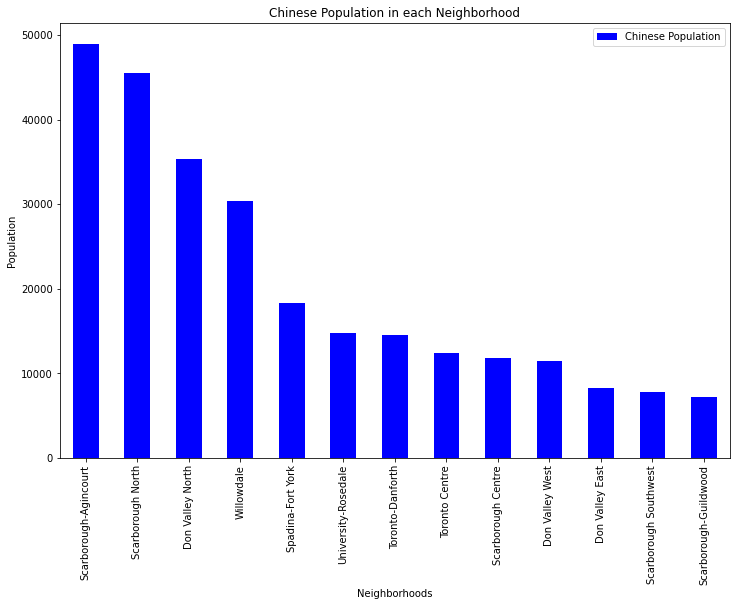

In [87]:
# graph shows the percentage of chinese with respect to neighbors 
bar_graph = pop_chinese_df_percentage.sort_values(by='Chinese Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Chinese Population',figsize=(12,8), color='blue')
plt.title("Chinese Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

This graph shows relationship between neighborhoods & Chinese population.
This helps us to identify highly populated Chinese neighborhoods. Once we identify those neighborhoods it helps us in deciding where to place the new restaurant with Chinese cuisine.


### 3.4 Identify Relationship between Chinese Population and Chinese Restaurants
First get the list of neighborhoods present in the riding using the wikipedia geography section for each riding. Altering the riding names to match the wikipedia page so we can retrieve the neighborhoods present in those ridings


In [88]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_chinese_df_percentage['Riding'].to_list()
#print(riding_list)
riding_list[riding_list.index('Willowdale')] = 'Willowdale (electoral district)'
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list[riding_list.index('Toronto-Danforth')] = 'Danforth (electoral district)'
riding_list

['Willowdale (electoral district)',
 'Don Valley North',
 'Don Valley West',
 'Don Valley East',
 'Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Spadina-Fort York',
 'Danforth (electoral district)',
 'University-Rosedale',
 'Toronto Centre']

In [89]:
#Scraping wiki page to get the neighborhoods of ech Ridings
import wikipedia

Riding_neighborhood_df = pd.DataFrame()
print(len(riding_list))
for item in riding_list:
    wiki = wikipedia.WikipediaPage(item)         
    section = wiki.section('Geography')
    #print(item+ "............", item, section)
    if section != None:
        start = section.index("neighbourhoods of") + 17
        #print("start",start)
        stop = section.index('.',start)
        #print("stop,",stop)
        Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df.head()


13


,Riding,Neighborhoods
0,Willowdale (electoral district),"Willowdale, Lansing, Newtonbrook and North Yo..."
1,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St..."
2,Don Valley West,"York Mills, Silver Hills, the western half of..."
3,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
4,Scarborough Centre (electoral district),Scarborough City Centre (west of McCowan Road...


In [90]:
#Merging the pop_Chinese_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.
Neigh_pop = pd.merge(pop_chinese_df_percentage, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop.head()

,Chinese Population,Neighborhoods
0,35335.44,"Henry Farm, Bayview Village, Bayview Woods-St..."
1,11400.48,"York Mills, Silver Hills, the western half of..."
2,8292.13,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,7797.24,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
4,48985.75,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."


In [91]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
#print(Neigh_pop['split_neighborhoods'])

Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Chinese Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop.head()

,Chinese Population,Neighborhood
0,35335.44,Henry Farm
1,11400.48,York Mills
2,8292.13,Flemingdon Park
3,7797.24,Birch Cliff
4,48985.75,Steeles


In [79]:
toronto_chinese_rest.head()

,Cluster Labels,Chinese Restaurant,Neighborhood
0,0,0.000000,Agincourt
1,0,0.000000,Alderwood
2,2,0.047619,Bathurst Manor
3,4,0.250000,Bayview Village
4,0,0.000000,Bedford Park


In [92]:
# we have splited the neighborhoods in each Riding and merge the population in each neighborhood
# and this help us to find the number of resaurants in each neighborhood

toronto_chinese_rest['split_neighborhoods'] = toronto_chinese_rest['Neighborhood'].str.split(',') 
toronto_chinese_rest.drop(columns=['Neighborhood'],inplace=True,axis=1)

toronto_chinese_rest = toronto_chinese_rest.split_neighborhoods.apply(pd.Series).merge(toronto_chinese_rest, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Chinese Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_chinese_rest.reset_index()
toronto_chinese_rest.head()


,Chinese Restaurant,Neighborhood
0,0.000000,Agincourt
1,0.000000,Alderwood
2,0.047619,Bathurst Manor
3,0.250000,Bayview Village
4,0.000000,Bedford Park


In [93]:
# the Df with percentage of restaurant are merged with neighborhood population DF
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_chinese_rest, on='Neighborhood')
pop_merged_restaurant_percent.head(10)

,Chinese Population,Neighborhood,Chinese Restaurant
0,35335.440,Henry Farm,0.014085
1,11400.480,Silver Hills,0.000000
2,7797.240,Oakridge,0.000000
3,7179.165,Morningside,0.000000
4,7797.240,Clairlea,0.000000


## 4. Predictive Analysis <a id="4"></a>

### 4.1 Clustering Toronto Neighborhoods
- First identify best K cluster value for K-mean clustering using Chinese Restaurants 
- We use dataframe ***toronto_chinese_rest*** that contains ***percentage of Chinese resuturants*** in neighborhoods 


In [94]:
toronto_chinese_rest.head()

,Chinese Restaurant,Neighborhood
0,0.000000,Agincourt
1,0.000000,Alderwood
2,0.047619,Bathurst Manor
3,0.250000,Bayview Village
4,0.000000,Bedford Park


In [95]:
from sklearn.cluster import KMeans

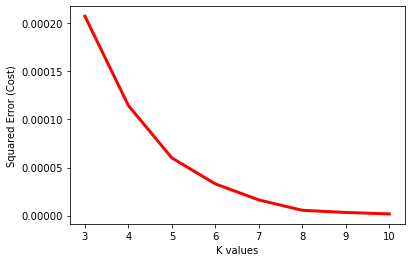

In [96]:
# identify number of suitable clusters
toronto_chinese_rest_clustering = toronto_chinese_rest.drop('Neighborhood', 1)
error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_chinese_rest_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()



#### The visual analysis using albow method using distortion score & Squared error for each K value, looks like K = 5 is the best value.

In [97]:
clusters =5
toronto_chinese_rest_clustering = toronto_chinese_rest.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(toronto_chinese_rest_clustering)

kmeans.labels_

array([0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [98]:
toronto_chinese_rest.insert(0, 'Cluster Labels', kmeans.labels_)


In [99]:
toronto_chinese_rest.head()

,Cluster Labels,Chinese Restaurant,Neighborhood
0,0,0.000000,Agincourt
1,0,0.000000,Alderwood
2,2,0.047619,Bathurst Manor
3,3,0.250000,Bayview Village
4,0,0.000000,Bedford Park


In [100]:
toronto_merged_new = toronto_df
toronto_merged_new.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [101]:
# merge toronto_data to add latitude/longitude for each neighborhood
toronto_merged_new = toronto_merged_new.join(toronto_chinese_rest.set_index('Neighborhood'), on='Neighborhood')
toronto_merged_new.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged_new.reset_index(drop=True, inplace=True)
toronto_merged_new['Cluster Labels'].astype(int)
toronto_merged_new.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.0,0.0
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0


In [102]:
toronto_merged_with_cluster_labels = toronto_merged_new
toronto_merged_with_cluster_labels.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.0,0.0
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0


### 4.2 Visualization of Restaurant Clusters in Neighborhoods
- Using Folium map we have visualize five restaurant clusters

In [105]:
import matplotlib.cm as cm
import matplotlib.colors as colors

clusters_map = folium.Map(
    location=[latitude, longitude], 
    zoom_start=11,
    width='90%',
    height='70%')

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_with_cluster_labels['Latitude'],
                                  toronto_merged_with_cluster_labels['Longitude'],
                                  toronto_merged_with_cluster_labels['Neighborhood'],
                                  toronto_merged_with_cluster_labels['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters_map)


<div style= "text-align:center">
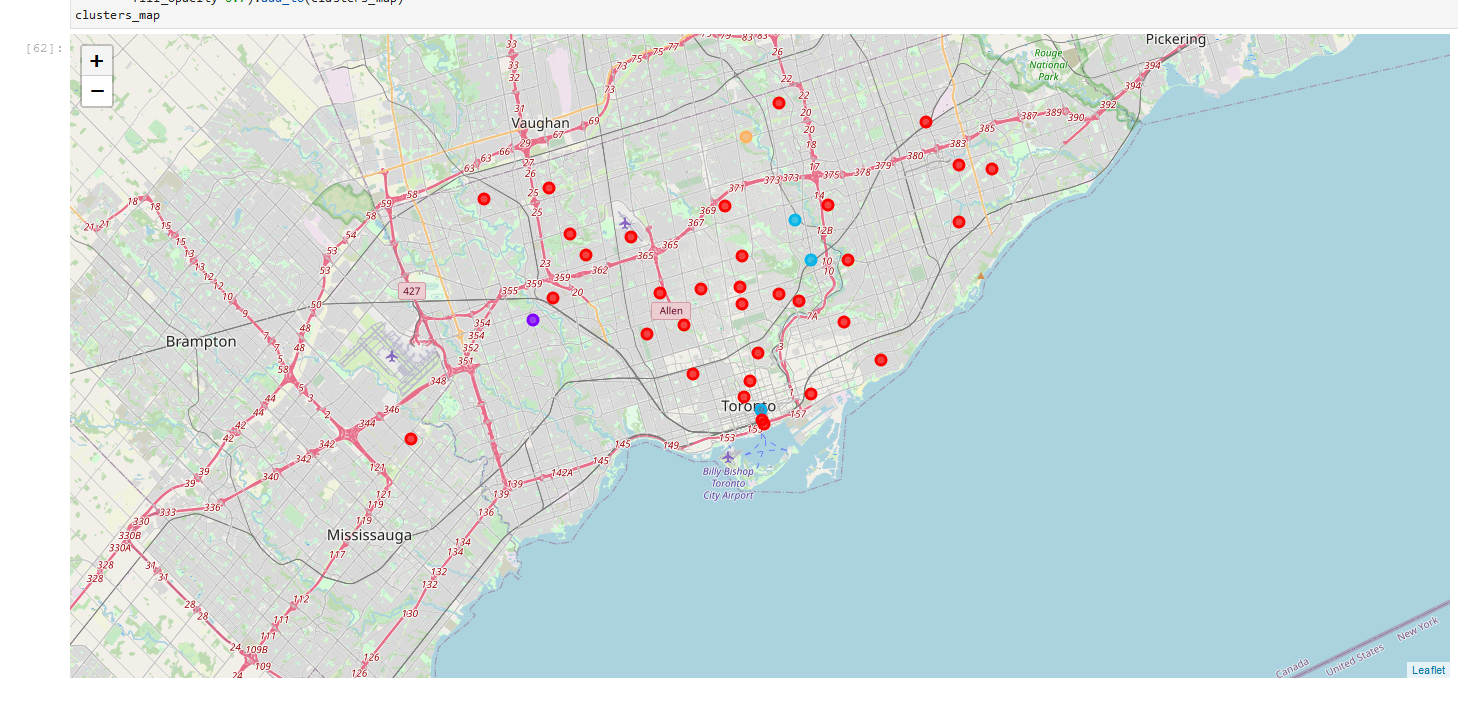
<div>
     <a>Visualization of Restaurant Clusters in Neighborhoods using folium Map
    </a>
    </div>
</div>


### 4.3 Examining the Clusters
- We have total number of 5 clusters
- We will examining individual cluster 

### Cluster 0 contains all the neighborhoods which has least number of Chinese restaurants. It is shown in red color in the map

In [106]:
#Cluster 0
cluster_0 = toronto_merged_with_cluster_labels.loc[toronto_merged_with_cluster_labels['Cluster Labels'] == 0]
cluster_0.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.0,0.0
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0


### Cluster 1 contains all the neighborhoods which is medium-to-high populated with Chinese restaurants. It is shown in purple color in the map

In [107]:
#Cluster 1
cluster_1 = toronto_merged_with_cluster_labels.loc[toronto_merged_with_cluster_labels['Cluster Labels'] == 1]
cluster_1.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
17,Etobicoke,M9P,Westmount,43.696319,-79.532242,1.0,0.166667


### Cluster 2 contains all the neighborhoods which are medium populated with Chinese restaurants. It is shown in blue color in the map.

In [108]:
#Cluster 2
cluster_2 = toronto_merged_with_cluster_labels.loc[toronto_merged_with_cluster_labels['Cluster Labels'] == 2]
cluster_2.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,2.0,0.04
23,North York,M3B,Don Mills,43.745906,-79.352188,2.0,0.04
24,North York,M3C,Don Mills,43.725900,-79.340923,2.0,0.04


### Cluster 3 contains all the neighborhoods which is densely populated with Chinese restaurants. It is shown in light green color in the map.

In [109]:
#Cluster 3
cluster_3 = toronto_merged_with_cluster_labels.loc[toronto_merged_with_cluster_labels['Cluster Labels'] == 3]
cluster_3.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
20,North York,M2K,Bayview Village,43.786947,-79.385975,3.0,0.25


### Cluster 4 has no rows meaning no data points or neighborhood was near to this centroid.

In [110]:
#Cluster 4
cluster_4 = toronto_merged_with_cluster_labels.loc[toronto_merged_with_cluster_labels['Cluster Labels'] == 4]
cluster_4.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant


## 5. Results and Discussion <a id="5"></a>

### 5.1 Results

<p>
This section concludes the finding of the overall data analysis. In this project, we aim at identifying suitable neighborhood location in Toronto to establish a new Chinese restaurant. For spatial and non-spatial neighborhood data we used the web resources like Wikipedia and Geospatial data. For the extracting and scraping Wikipedia data we used Foursquare API and different python packages such as Wikipedia and beautifulsoup4.   
    
We used Toronto neighborhood data and demographic data such as Chinese population in each neighborhood and percentage of existing Chinese restaurants in those neighborhoods. The k-mean clustering technique is used to find the suitable neighborhood for establishing new Chinese restaurant.
</p>

- For the analysis we considered boroughs: Central Toronto, Downtown Toronto, East Toronto, East York, Etobicoke, Mississauga, North York, Scarborough, and York with 103 neighborhoods.

- Using Foursquare API we have extracted top 274 unique venues in Toronto neighborhoods. We are interested in Chinese restaurant in the neighborhoods. Therefore, we group neighborhoods and percentage of Chinese restaurants.

- In those 10 boroughs we identified that the neighborhoods of Downtown Tronto, Etobicoke, and North York boroughs have high amount of Chinese restaurants with the help of Violin plots between Number of Chinese restaurants in Borough of Toronto.

- The relationship between neighborhoods and Chinese restaurants indicates that Scarborough-Agincourt has highest population and Scarborough-Guildwood has lowest population.

- With the help of k-means clustering and plot visualization looks like Downtown Toronto, Central Toronto, East Toronto, East York, Mississauga, Scarborough, York have least number of Chinese restaurants. 

- Etobicoke and North York are densely populated with Chinese restaurants.

<p>
After predictive analysis we came to conclusion that Central Toronto, East Toronto, East York, Mississauga, and Scarborough are ideal locations for opening new Chinese restaurant. However, the population analysis further clarify that Scarborough is most populated borough. Therefor, it has higher number of customers possibility.   
Thus we can conclude that Scarborough is most suitable location for opening a new Chinese restaurant.
</p>



### 5.2 Discussion
<p>
According to the predictive analysis, Scarborough borough is the most suitable location for the new Chinese restaurant as there are few Chinese restaurants or no restaurants in the neighborhoods. The relationship between Chinese population and Chinese restaurants also reveal the facts that Scarborough borough and neighborhoods are densely populated with Chinese immigrants. Thus the location has potential of having more customers. 
The data we have used in this analysis is based on 2016 census. Thus population distribution would have definitely changed by 2020. The predictive analysis need to be reconsider based on up available up to data demographic dataset.

</p>

## 6. Conclusion <a id="6"></a>
<p>
This section concludes the predictive analysis for finding suitable location to open new Chinese restaurant. We have use different python packages to extract and scrap the useful spatial and non-spatial data from Wikipedia. We have used Foursquare API to explore the venues in neighborhoods of Toronto. For the visual analysis, we have used seaborn & matplotlib, libraries and neighborhoods and clusters of locations are rendered using Folium leaflet library. Finally, we have used K-means clustering to find clusters of locations suitable for opening new Chinese restaurant.  
</p>